# All Life Bank Customer Segmentation

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

### Problem Definition

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Key Questions ###

* Which variables are most important for clustering?
* How many clusters do we need and how us each cluster is different from the others?
* What are the business recommendations?

## Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")


# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to compute distances
from scipy.spatial.distance import pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

<IPython.core.display.Javascript object>

In [64]:
## Loading the dataset

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_excel("../data/raw/CreditCardCustomerData.xlsx")

<IPython.core.display.Javascript object>

## Data Overview

### Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Checking the shape of the dataset

In [4]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

* We have 660 rows and 7 columns 

### Checking the first 5 and last 5 rows of the dataset

In [5]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [68]:
data.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


<IPython.core.display.Javascript object>

### Checking the data types of the columns for the dataset

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

* All columns are of numeric type


### Check misssing Values to confirm

In [70]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

* No Missing values

### Checking  Duplicate Values

In [71]:
# Check for duplicated values
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [6]:
data.loc[data.duplicated()]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


<IPython.core.display.Javascript object>

* We have no duplicate values

### Statistical summary of the dataset

In [73]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

### Data Overview Summary

* The average credit limit is 34,574 with 75% of the customers in the data set having a credit limit of 48,000 and above
* We observe that each customer has an average of 4 credit cards , 10 credit cards max looks like an outlier that needs to be investigated
* A customer makes 0 to 5 visits to the bank with an average of 2 visits
* Online visits are a bit higher with 3 average visits. We observe a max of 15 visits
* On average customers make 3 - 4 callse
* We also observe that 75% of the customers have made 5 or more calls

## Exploratory Data Analysis (EDA)

### Declaring common Functions to be used for the EDA

In [74]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram


# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

### Univariate Analysis

`Avg_Credit_Limit`

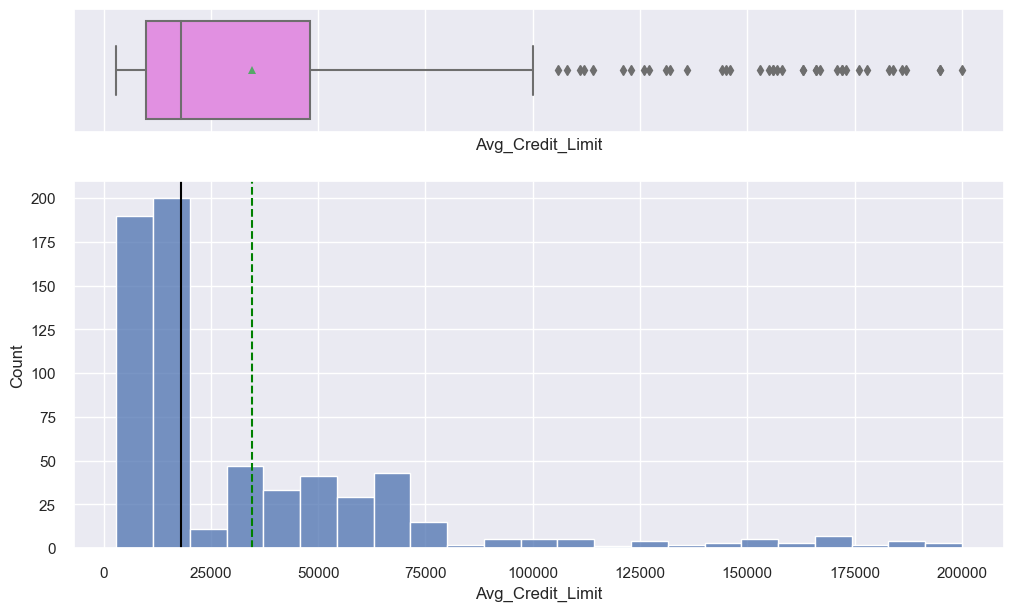

<IPython.core.display.Javascript object>

In [75]:
histogram_boxplot(data, "Avg_Credit_Limit")

* The distribution for Avg_Credit_Limit is right skewed
* Many outliers observed in this column

`Total_Credit_Cards`   

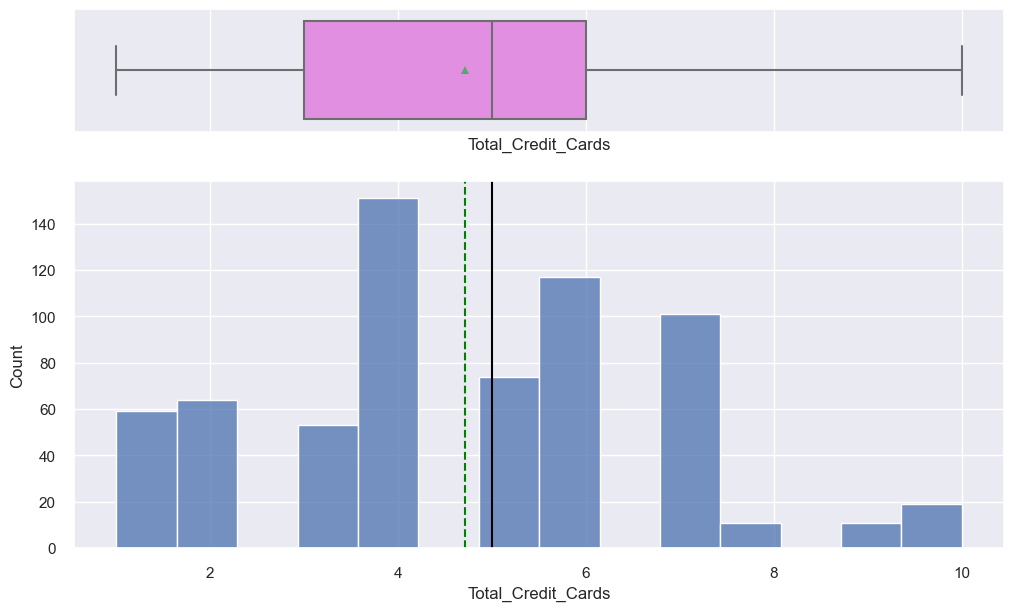

<IPython.core.display.Javascript object>

In [76]:
histogram_boxplot(data, "Total_Credit_Cards")

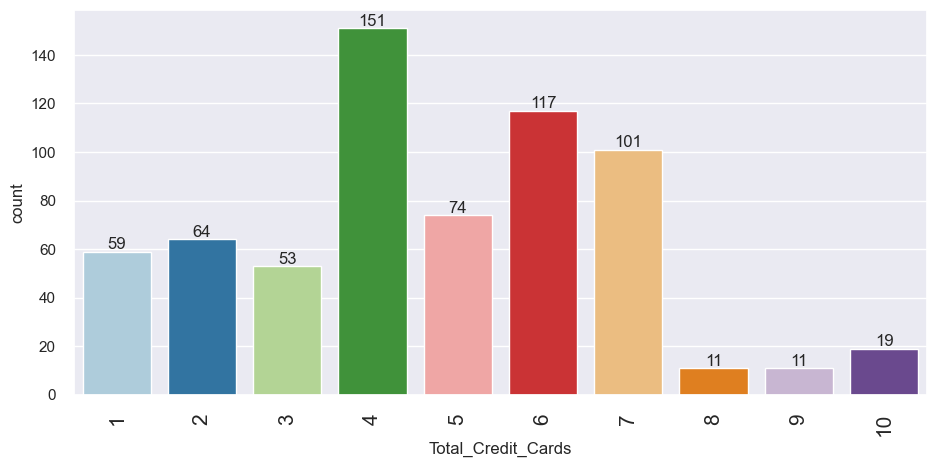

<IPython.core.display.Javascript object>

In [77]:
labeled_barplot(data, "Total_Credit_Cards")

* The distribution for this columns seems to be sparse
* Majority of customers have 4 and 6 cards respectively
* The distribution for this column is slightly right skewed

`Total_visits_bank`

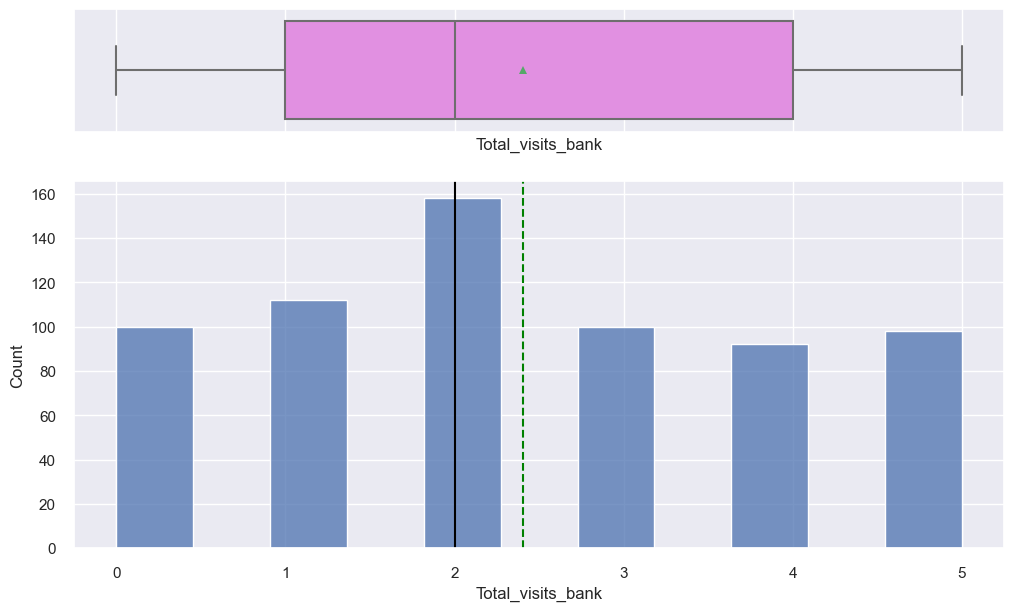

<IPython.core.display.Javascript object>

In [78]:
histogram_boxplot(data, "Total_visits_bank")

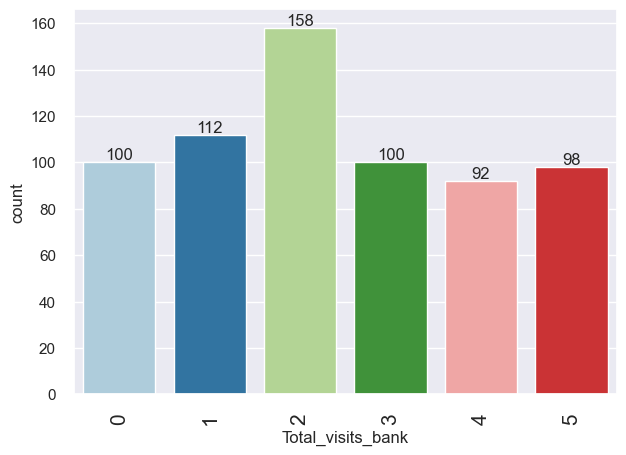

<IPython.core.display.Javascript object>

In [79]:
labeled_barplot(data, "Total_visits_bank")

* Majority of customers make 2 or more visits to the bank
* The distribution is left skewed

`Total_visits_online`

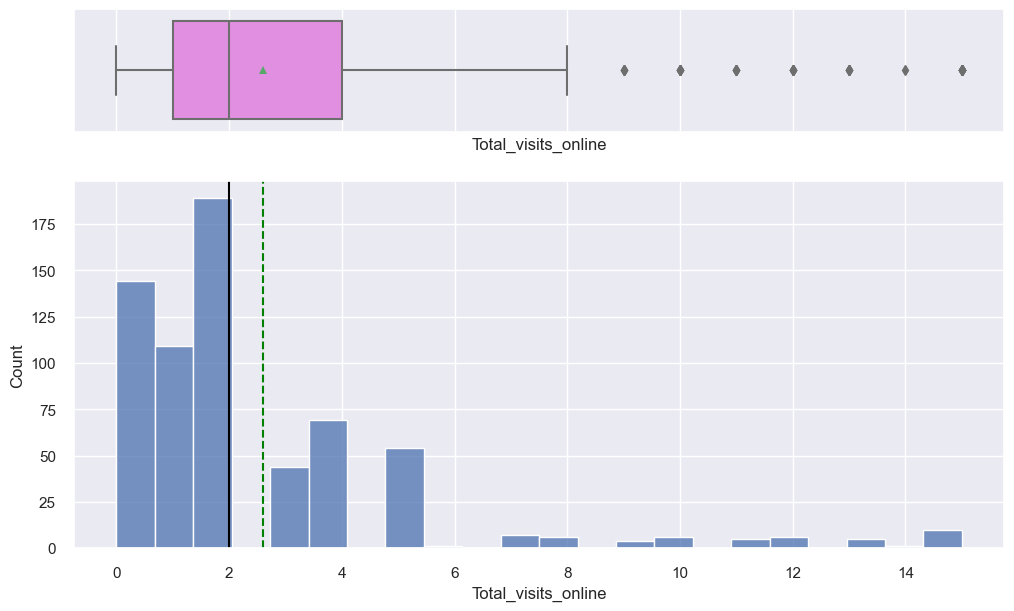

<IPython.core.display.Javascript object>

In [80]:
histogram_boxplot(data, "Total_visits_online")

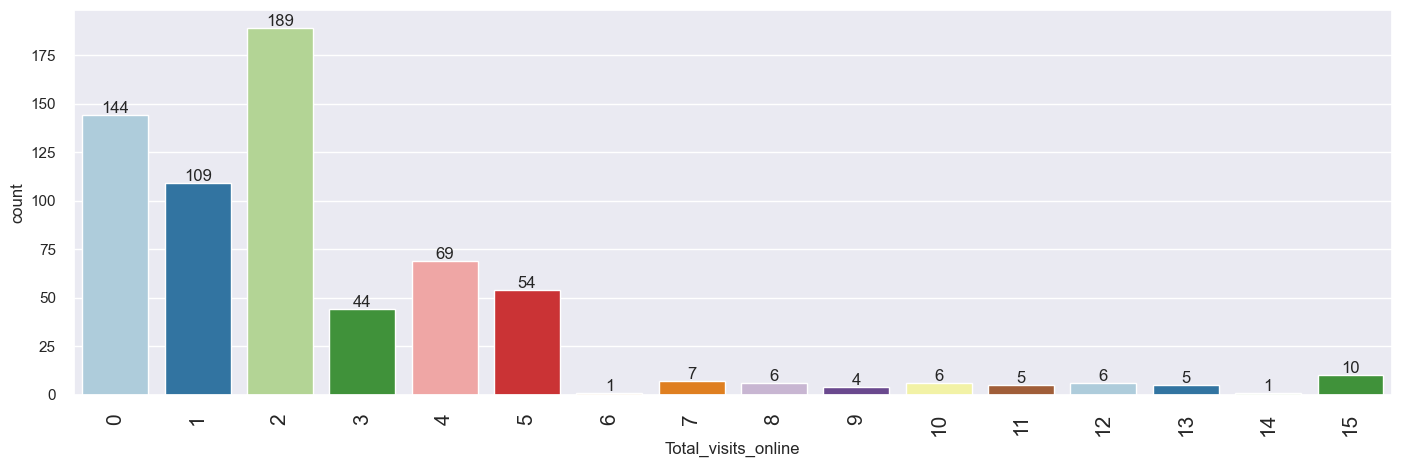

<IPython.core.display.Javascript object>

In [81]:
labeled_barplot(data, "Total_visits_online")

* The distribution for this columns is right skewed with many outliers observed

`Total_calls_made`

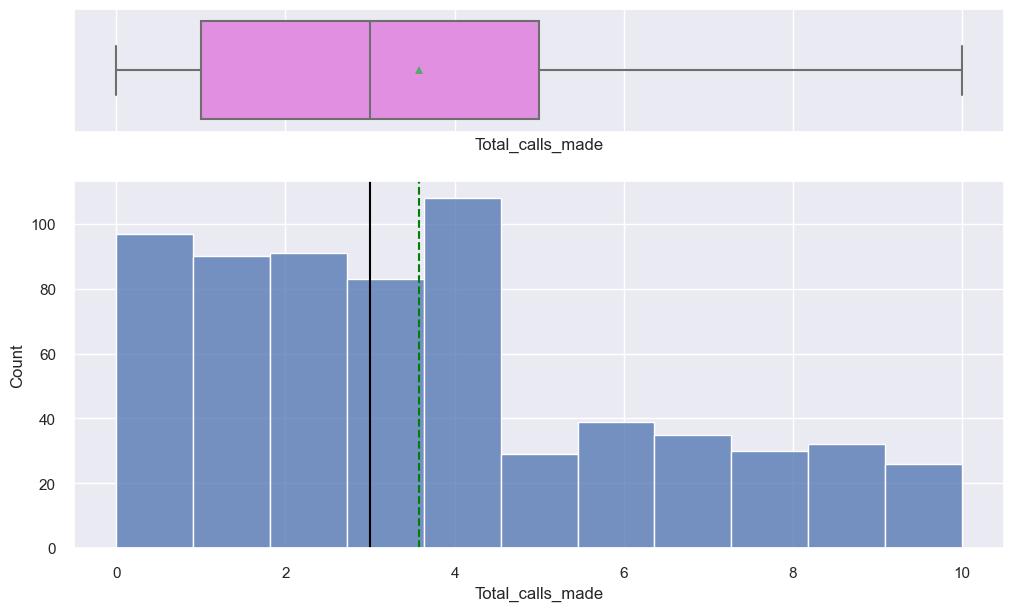

<IPython.core.display.Javascript object>

In [82]:
histogram_boxplot(data, "Total_calls_made")

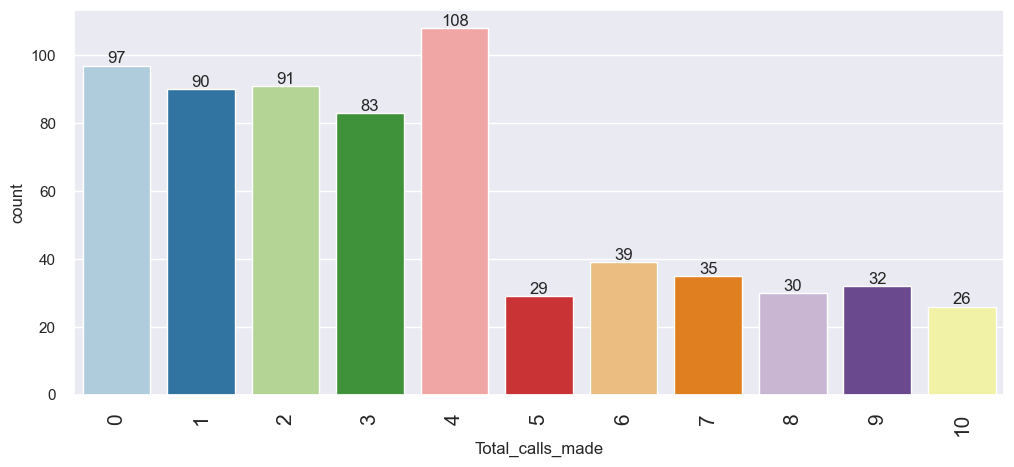

<IPython.core.display.Javascript object>

In [83]:
labeled_barplot(data, "Total_calls_made")

* We observe majority of the number of calls ranging from 0 to 4
* Column distribution is right skewed

### Bivariate Analysis

**Checking for Correlations**

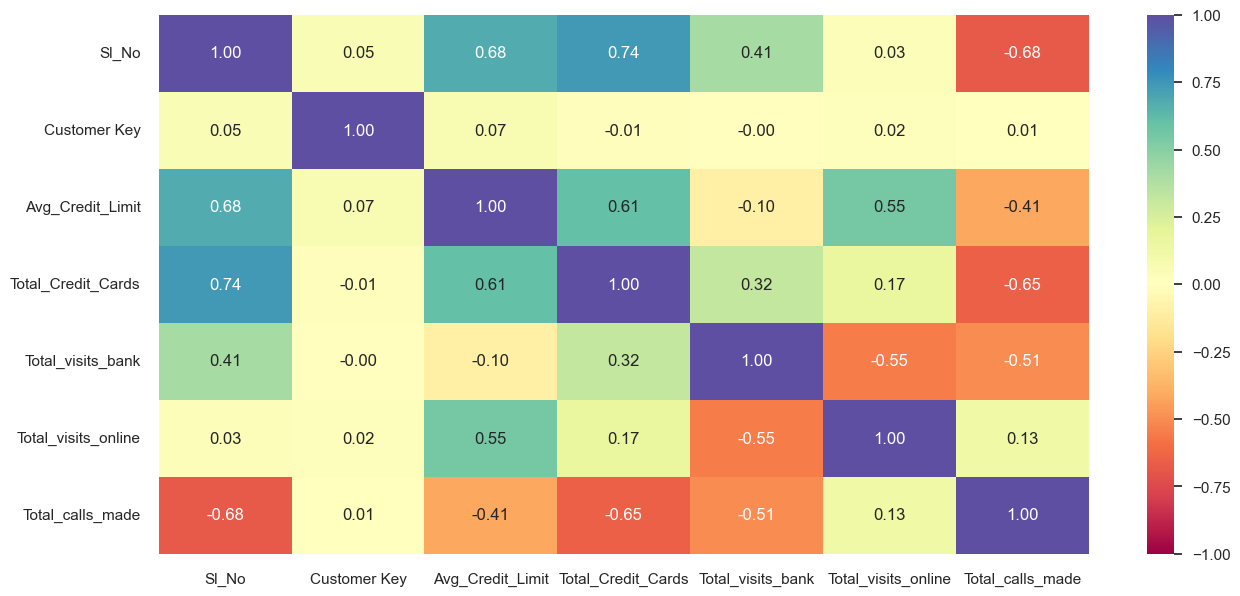

<IPython.core.display.Javascript object>

In [84]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

* Avg_Credit_Limit and  Total Visits online are positively correlated infering that the more the customer makes online visits the more likely they are to have a higher credit limit
* Likewise Avg_Credit_Limit and Total Credit Cards are postively correlated which is obvious. 
* Total visits Bank and Total Credit Cards are positively correlated meaning that more visits the more likely they are to obtain an additional credit card
* Likewise for total visits online and Total Credit Cards which are positively correlated meaning that more online visits the more likely they are to obtain an additional credit card

## Data Preprocessing

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

### Dropping unecessary columns ###

**Dropping S1_no & Customer Key columns**

In [86]:
data.drop("Sl_No", axis=1, inplace=True)
data.drop("Customer Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

**Making a copy of the original dataframe**

In [87]:
df_copy = data.copy()

<IPython.core.display.Javascript object>

### Feature Scaling

**Scaling Avg_Credit_Limit Variables for uniformity before clustering**

**Dataset before scaling**

In [88]:
df_copy

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


<IPython.core.display.Javascript object>

**Scaling the column**

In [89]:
num_col = df_copy.select_dtypes(include=np.number).columns.tolist()
num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

In [90]:
scaler = StandardScaler()
df_copy["Avg_Credit_Limit"] = scaler.fit_transform(df_copy[["Avg_Credit_Limit"]])

<IPython.core.display.Javascript object>

**Dataset after scaling**

In [91]:
df_copy

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,2,1,1,0
1,0.410293,3,0,10,9
2,0.410293,7,1,3,4
3,-0.121665,5,1,1,4
4,1.740187,6,0,12,3
...,...,...,...,...,...
655,1.713589,10,1,10,0
656,1.314621,10,1,13,2
657,2.937092,8,1,9,1
658,3.655235,10,1,15,0


<IPython.core.display.Javascript object>

* We observe a more standardized value for the `Avg_Credit_Limit` column
* Also we observe negative values in the column which is not realistic. We need to treat this accordingly

## K-Means Clustering

**We will choose 7 clusters as initial count and determine the optimum/best clsuters from  silhouette scores**

### Calculate Average Distortion & Plot Elbow Method

Number of Clusters: 1 	Average Distortion: 4.469116832876134
Number of Clusters: 2 	Average Distortion: 3.162779538578063
Number of Clusters: 3 	Average Distortion: 2.4693428989579935
Number of Clusters: 4 	Average Distortion: 2.264958445140135
Number of Clusters: 5 	Average Distortion: 2.08654430182874
Number of Clusters: 6 	Average Distortion: 2.0123760219440054


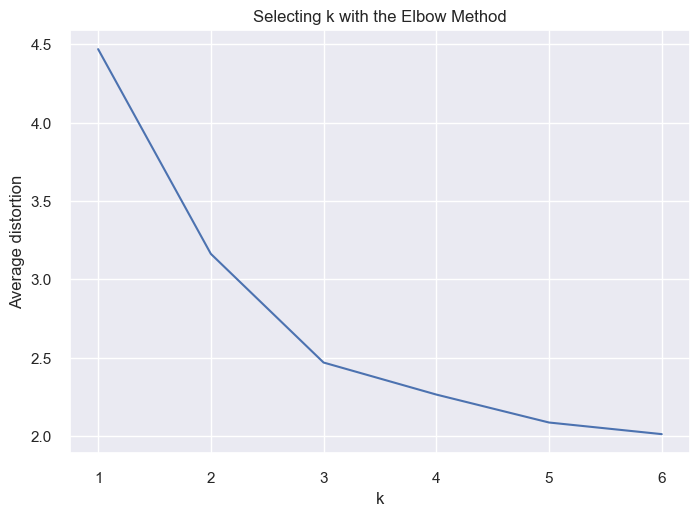

<IPython.core.display.Javascript object>

In [92]:
clusters = range(1, 7)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_copy)
    prediction = model.predict(df_copy)
    distortion = (
        sum(np.min(cdist(df_copy, model.cluster_centers_, "euclidean"), axis=1))
        / df_copy.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Appropriate value for k seems to be 2 or 3.**

### Calculate the Silhouette Scores

For n_clusters = 2, the silhouette score is 0.4478766101685377)
For n_clusters = 3, the silhouette score is 0.546215942925802)
For n_clusters = 4, the silhouette score is 0.3449001064473671)
For n_clusters = 5, the silhouette score is 0.2957468032490931)
For n_clusters = 6, the silhouette score is 0.2812494414335564)
For n_clusters = 7, the silhouette score is 0.2609886819572241)


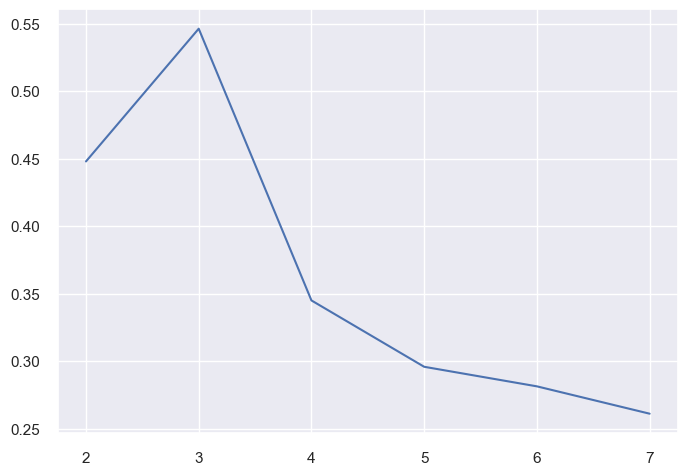

<IPython.core.display.Javascript object>

In [93]:
sil_score = []
cluster_list = list(range(2, 8))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((df_copy))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_copy, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

**The silhoutte score for 3 is higher than 2 hence we will choose 3 as our k**

### Visualize Silhouette Score

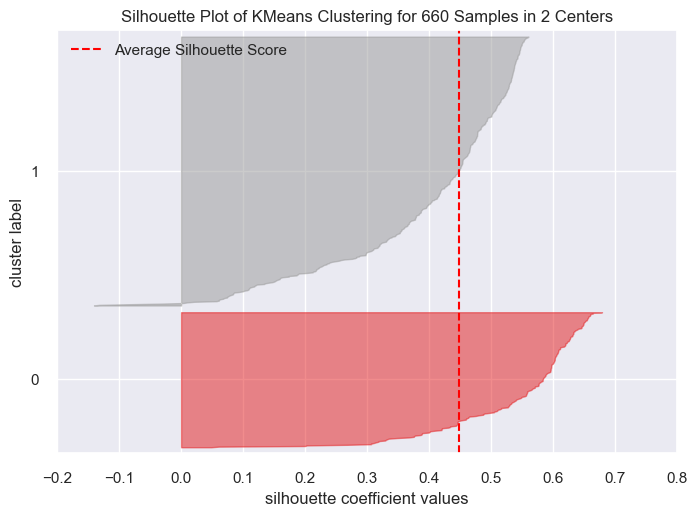

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [94]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(df_copy)
visualizer.show()

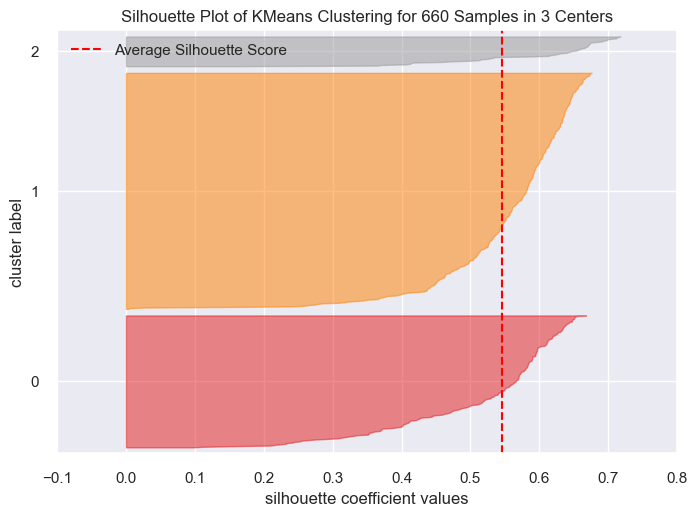

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [95]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(df_copy)
visualizer.show()

**Observations**

* K =3 seems to be the most appropriate cluster size given the higher silhoutte score
* K= 2 is not appropriate because it has a negative silhoutte coeficient value from the SilhouetteVisualizer

### Applying KMeans clustering for k=3

In [96]:
df_copy_kmeans = df_copy
data_kmeans = data
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_copy_kmeans)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [97]:
# adding kmeans cluster labels to the original dataframe
data_kmeans["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [98]:
cluster_profile_km = data_kmeans.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [99]:
cluster_profile_km["count_in_each_segment"] = (
    data_kmeans.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [100]:
# let's display cluster profiles
cluster_profile_km.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12223.744292,2.388128,0.931507,3.589041,6.958904,219
1,33478.260870,5.488491,3.457801,0.994885,2.012788,391
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

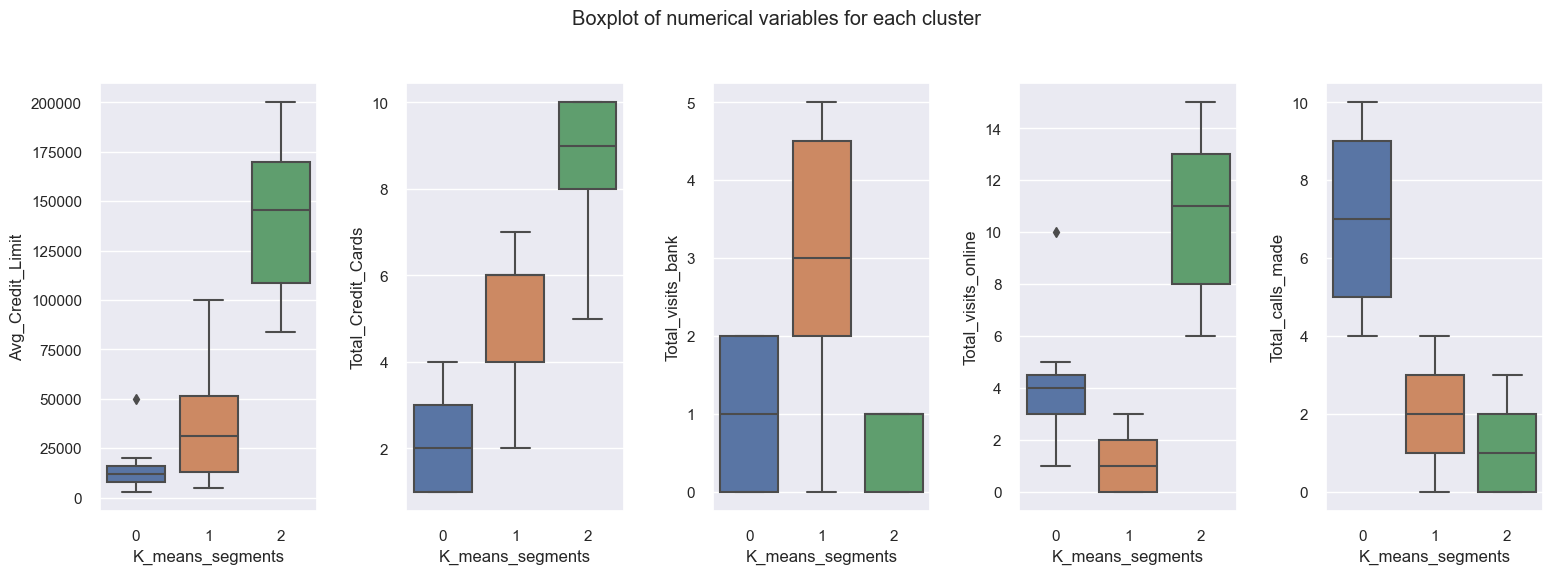

<IPython.core.display.Javascript object>

In [101]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=data_kmeans[num_col[counter]], x=data_kmeans["K_means_segments"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    
    - This cluster contains customers with the lowest average credit limits compared to other clusters, this could indicate that the spending for this category of customers is low
    - This cluster has the lowest number of credit cards issued ranging from 0 to 3
    - The total number of visits to the bank for this customer ranges from 0 to 2 lower than cluster 1 but slightly in the same range as cluster 2
    - Total online visits from this cluster range from 3 to 5, still low probabbly because customers on this cluster have lower limits hence lower spending and lower complaints etc
    - The total number of calls made is highest, meaning that customers from this cluster enquire more or have alot of issues to be addressed
    
   

- **Cluster 1**:
    - This cluster has the highest number of customers
    - This cluster contains customers with low average credit limits (Less than the average), ranging from 20,000 to 50,000 , this could also indicate that the spending for this category of customers is low
    - We observe an average total credit cards count for this cluster ranging from 4 to 6 credit cards
    - The total number of visits to the bank for this customer categiry is the hightest. This could point to an underlying issue causing customer dissatisfaction that probably the bank needs to investigate.
    - Total online visits from this cluster range are lowest. 
    - Total number of calls to the bank are lower than average meaning that they prefer visiting the bank for enquiries
    

- **Cluster 2**:
    - This cluster contains customers with the highest average credit limits. This could mean that customers in this clusters are high spenders
    - The group also has the highest number of credit cards which makes sense because teh average credit limit is also high
    - The total number of visits to the bank for this customer categiry is low. This could mean that customers in this category are satisfied with the service offered by the bank
    - Total online visits from this cluster range are the highest. 
    - We observe fewer calls to the bank from customers in this cluste

## Hierachical Clustering

**Defining global variables**

In [102]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

<IPython.core.display.Javascript object>

### Check Cophenetic Correlation Per Linkage Method & Distance Metric

In [103]:
high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_copy, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_copy))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.6718490377434932.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8565566207268376.
Cophenetic correlation for Euclidean distance and average linkage is 0.8786494593116221.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8705288383704456.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6568621928983467.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.870005218829745.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8773857816769701.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8655829631914106.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.651271943917988.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6366044563732927.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7808019940931932.
Cophenetic corr

<IPython.core.display.Javascript object>

In [104]:
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8786494593116221, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

**Euclidean distance seems to give the highest cophenetic correlation. Hence we will explore different linkage methods with Euclidean Distance only**

In [105]:
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df_copy, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df_copy))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.6718490377434932.
Cophenetic correlation for complete linkage is 0.8565566207268376.
Cophenetic correlation for average linkage is 0.8786494593116221.
Cophenetic correlation for centroid linkage is 0.8777103942251686.
Cophenetic correlation for ward linkage is 0.7551409796830063.
Cophenetic correlation for weighted linkage is 0.8705288383704456.


<IPython.core.display.Javascript object>

In [106]:
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8786494593116221, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**Observations**
- We observe that the cophenetic correlation is maximum with Euclidean distance and average linkage.

### Dendograms for Each Linkage Method

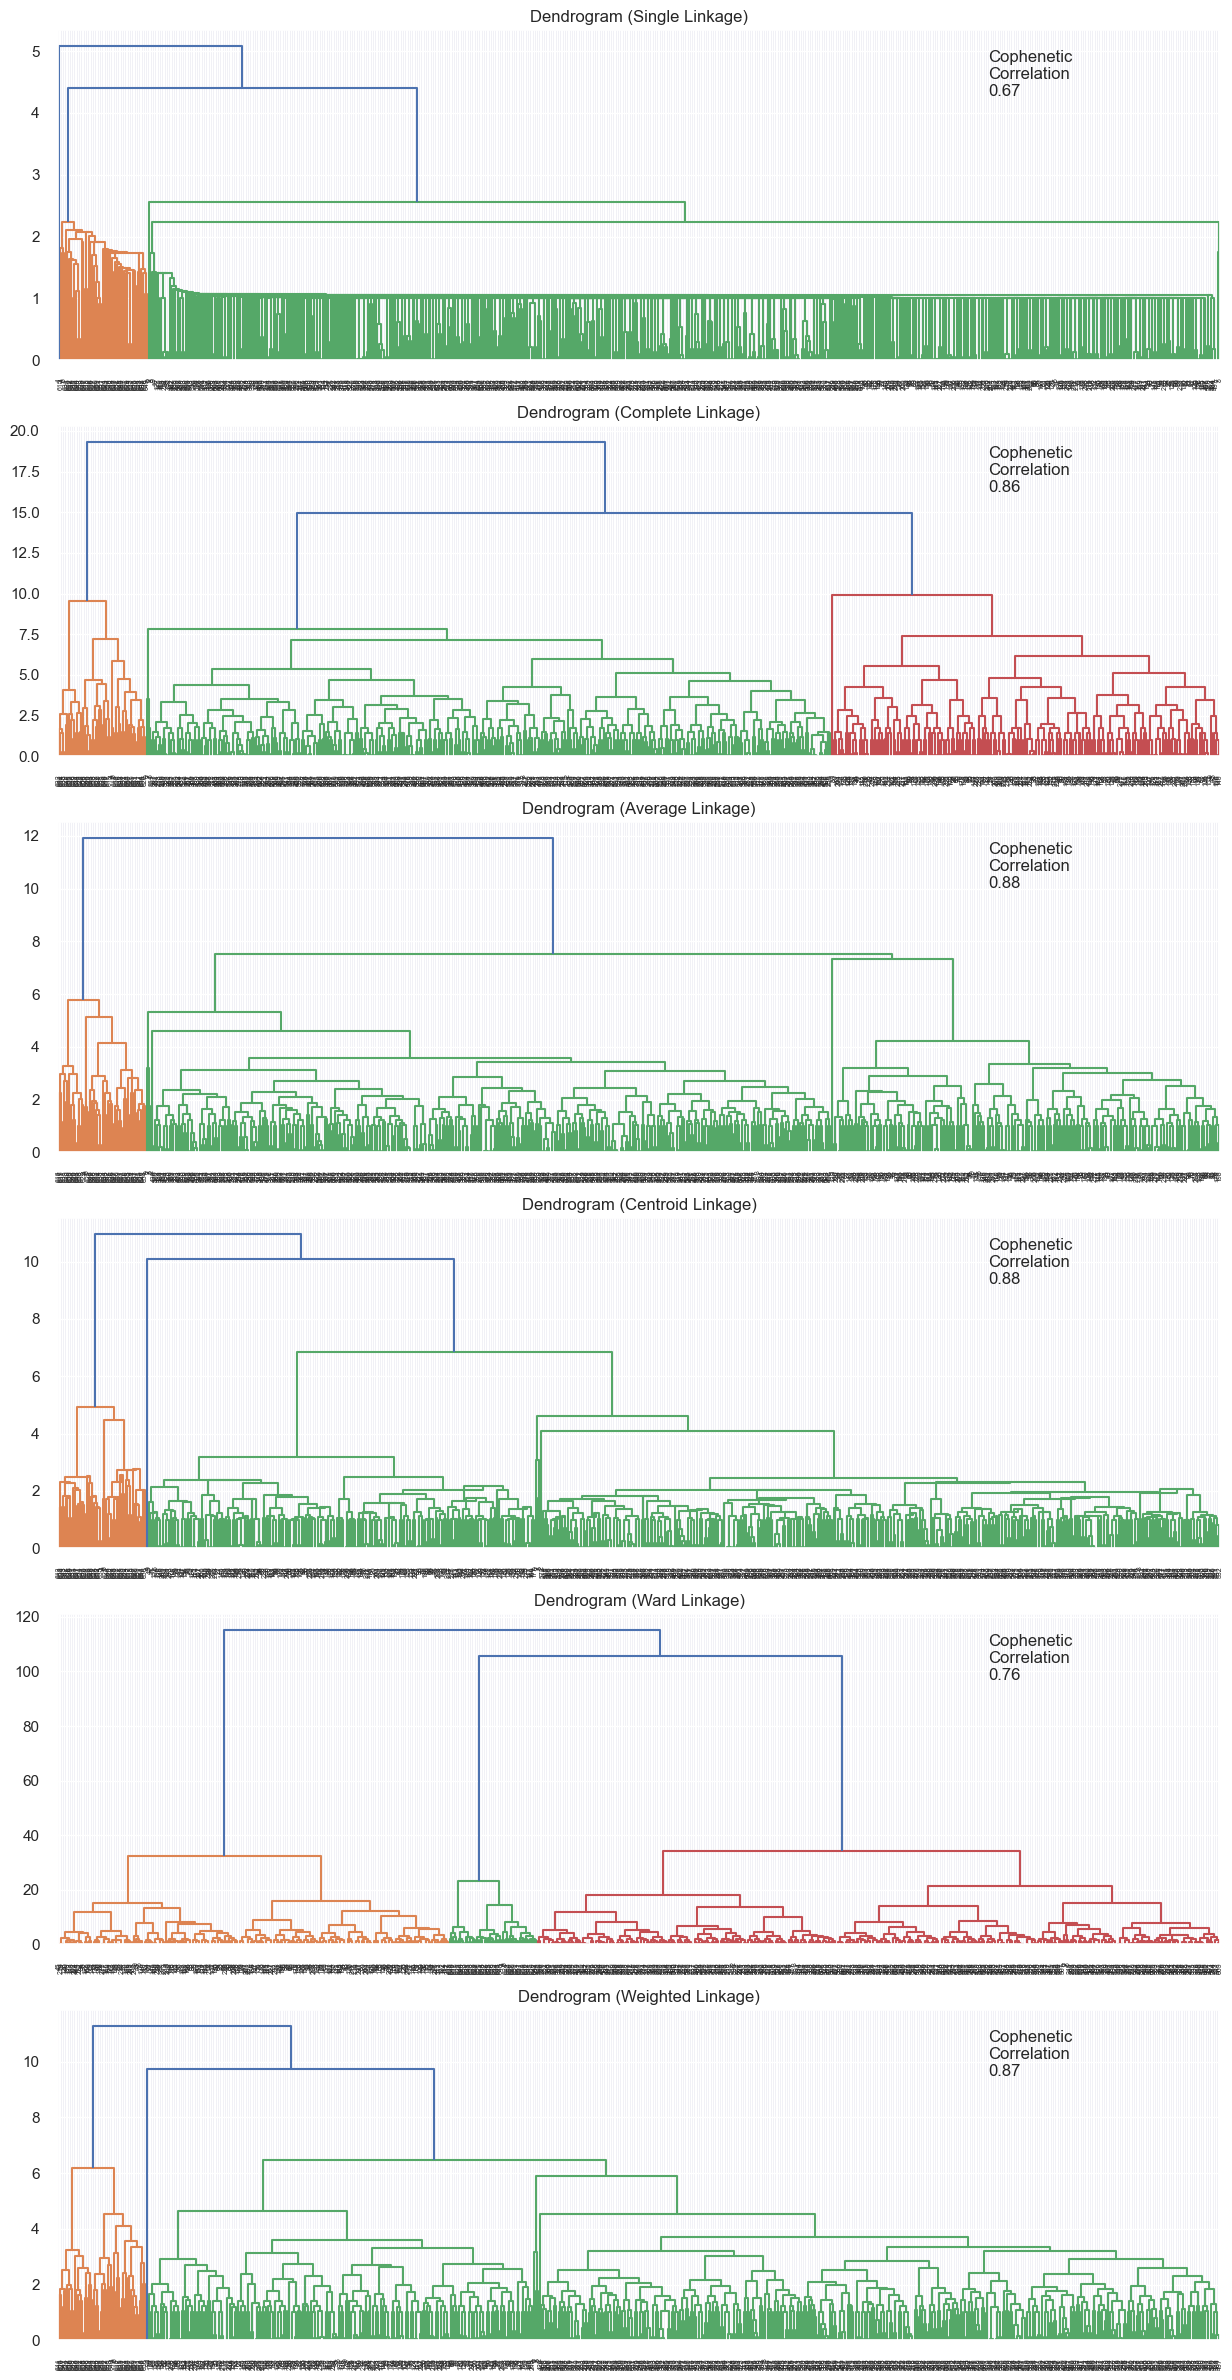

<IPython.core.display.Javascript object>

In [107]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []


fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))


for i, method in enumerate(linkage_methods):
    Z = linkage(df_copy, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_copy))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [108]:
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.671849
1,complete,0.856557
2,average,0.878649
3,centroid,0.877710
4,ward,0.755141
5,weighted,0.870529


<IPython.core.display.Javascript object>

#### Observations & Cluster Count Determination
* Despite having a lower cophenetic correlation values, the dendrogram for Ward linkage with Euclidean distance shows distinct and separate clusters with better variability
* At dendigram height 30, 5 would be the appropriate number of the clusters as observed from the ward linkage dendrogram visualization


### Applying Hierachical Clustering for different Linkage Methods

#### Visualizing Using and choosing best linkage method using Agglomerative Clustering

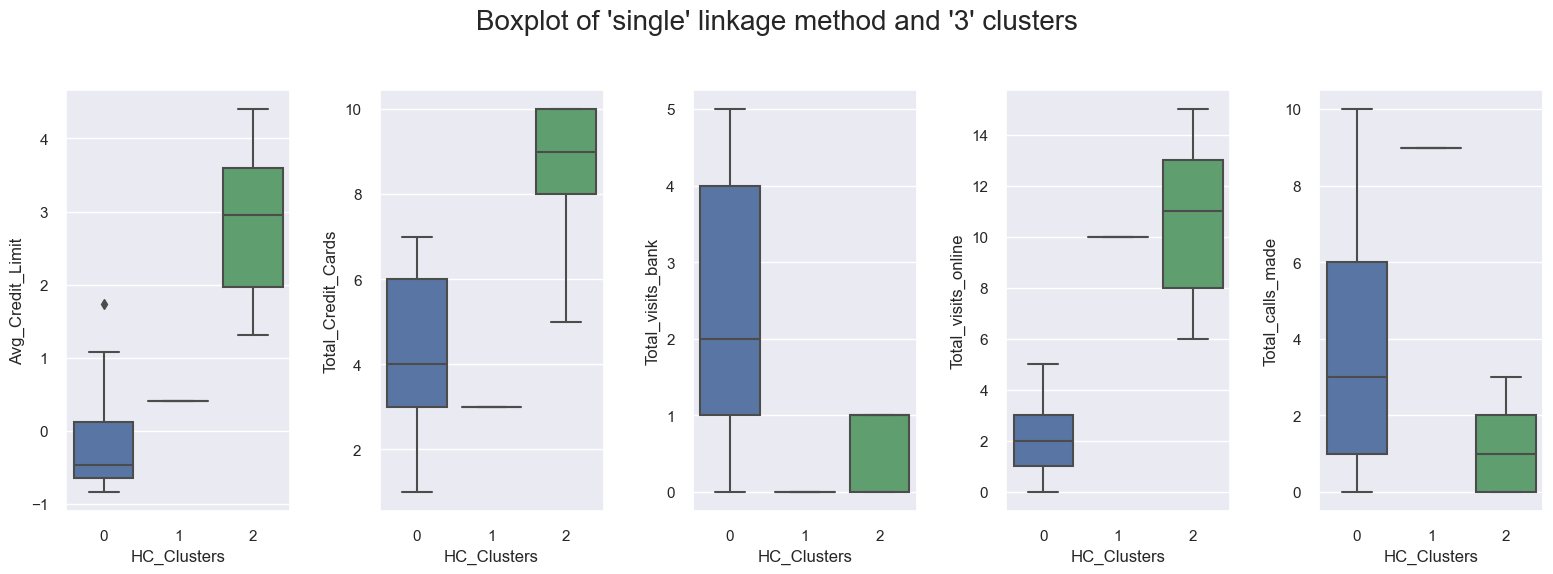

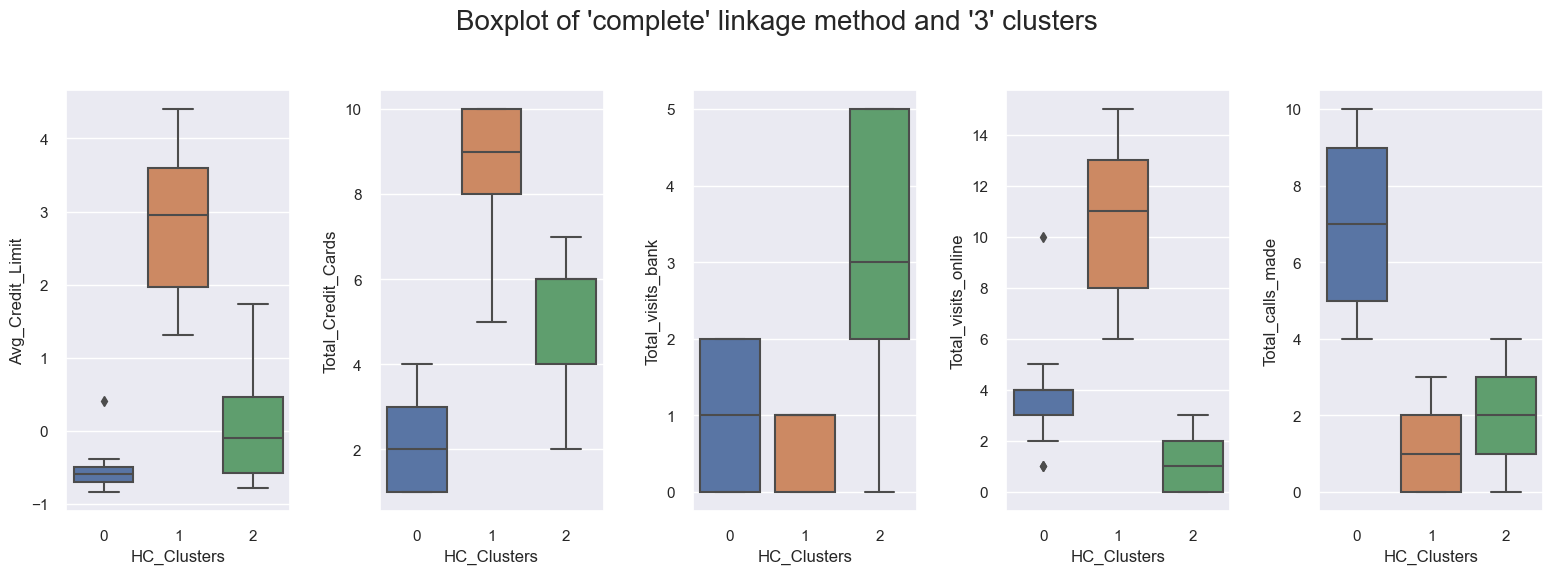

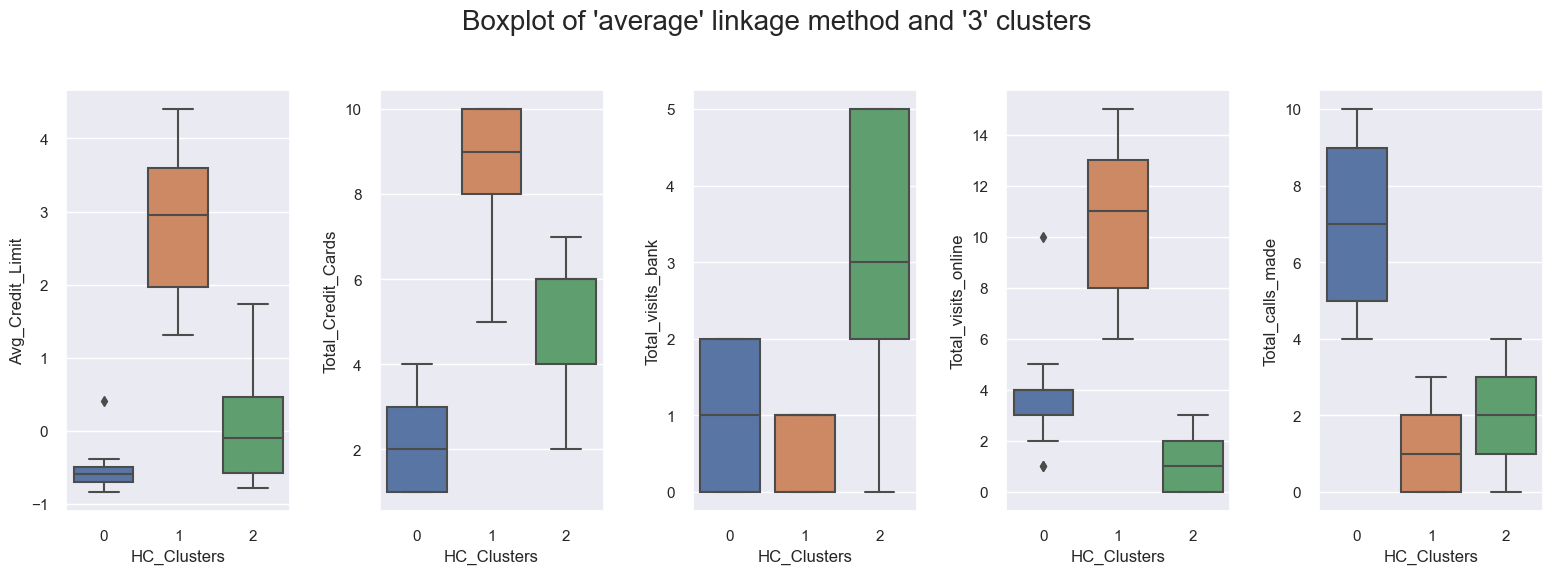

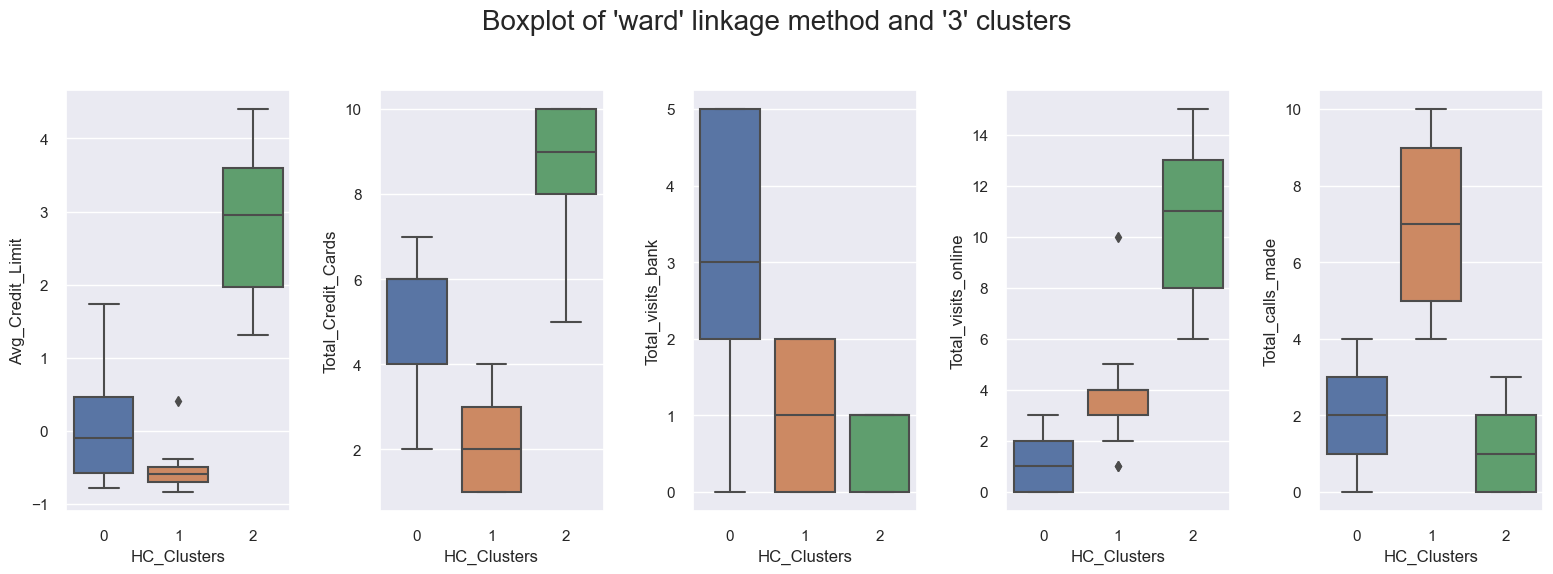

<IPython.core.display.Javascript object>

In [117]:
df_copy2=df_copy
data_2=data
linkage_methods = ["single", "complete", "average", "ward"]
for lm in linkage_methods:
    HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage=lm)
    HCmodel.fit(df_copy2)
    df_copy2["HC_Clusters"] = HCmodel.labels_
    data_2["HC_Clusters"] = HCmodel.labels_
    cluster_profile = data_2.groupby("HC_Clusters").mean()
    cluster_profile["count_in_each_segments"] = (data_2.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values)
    cluster_profile.style.highlight_max(color="lightgreen", axis=0)
    fig, axes = plt.subplots(1, 5, figsize=(16, 6))
    fig.suptitle(f"Boxplot of '{lm}' linkage method and '{HCmodel.n_clusters}' clusters", fontsize=20)
    counter = 0
    for ii in range(5):
        sns.boxplot(
        ax=axes[ii],
        y=df_copy2[num_col[counter]],
        x=df_copy2["HC_Clusters"],)
        counter = counter + 1

    fig.tight_layout(pad=2.0)
    


**Observations**
- Clustering for Single, Complete, and average linkages shows poor variability across different variables 
- Clustring using ward linkage method and 5 clusters seems more appropriate due to better variability across all variables 

### Cluster Profiling

In [110]:
df_copy_hc = df_copy
data_hc = data

<IPython.core.display.Javascript object>

In [111]:
cluster_profile_hc = df_copy_hc.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [112]:
cluster_profile_hc["count_in_each_segments"] = (
    data_hc.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [113]:
cluster_profile_hc.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,2.831764,8.740000,0.600000,10.900000,1.080000,50
1,-0.015163,5.408333,3.395833,1.029167,1.066667,240
2,-0.598147,2.442857,0.957143,3.450000,5.735714,140
3,-0.043835,5.637584,3.583893,0.919463,3.510067,149
4,-0.588606,2.333333,0.901235,3.802469,9.000000,81


<IPython.core.display.Javascript object>

In [114]:
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage=lm)
HCmodel.fit(df_copy_hc)
df_copy_hc["HC_Clusters"] = HCmodel.labels_
data_hc["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

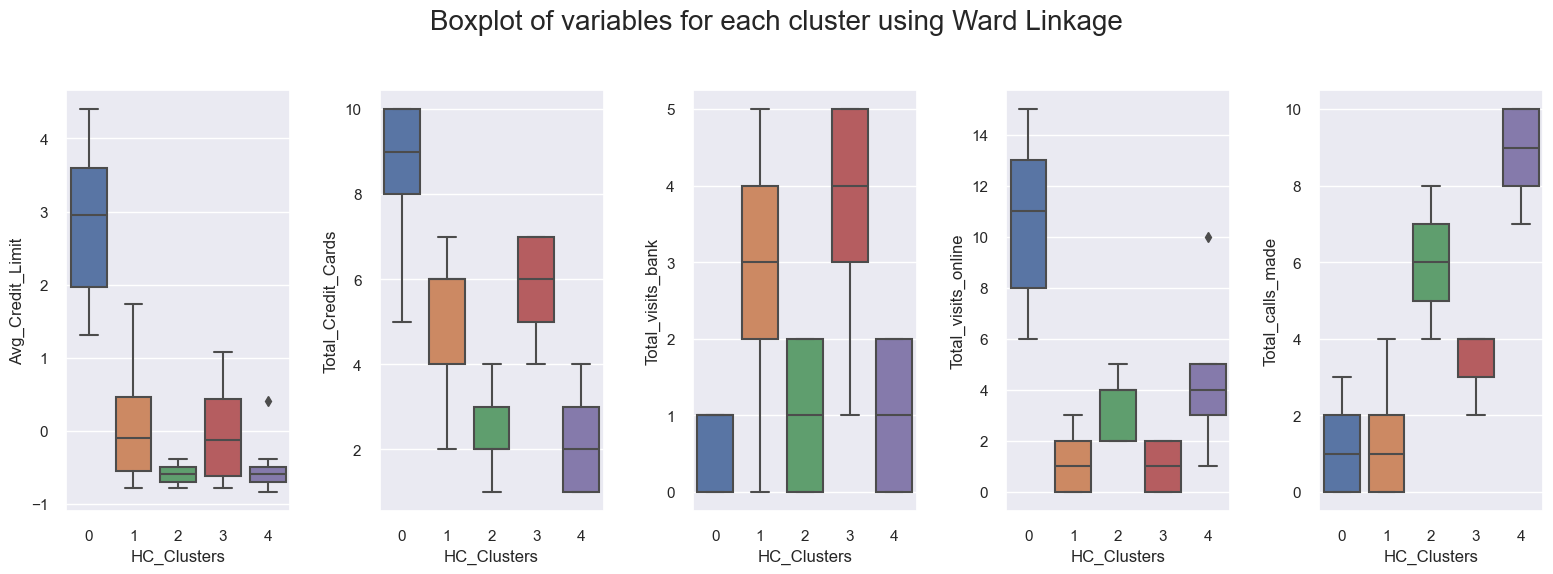

<IPython.core.display.Javascript object>

In [115]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of variables for each cluster using Ward Linkage", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=df_copy_hc[num_col[counter]],
        x=df_copy_hc["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    - This cluster has the lowest number of customers
    - This cluster contains customers with the highest Average Credit Limit compared to other clusters meaing that these represents a category of high spenders.
    - This cluster has the highest number of credit cards issued ranging from 8 to 10 which seems obvious given high average credit limit
    - The total number of visits to the bank for this customer ranges from 0 to 2 which is low meaning that customers in this cluster are somewhat satisfied with the service they are getting from the bank
    - Total online visits from this cluster  is the highest and ranges from 8 to 13, this could imply high usage 
    - We observe a lower total number of calls made to the bank meaning that the customers in this cluster prefer one-on-one bank visits
   

- **Cluster 1**:
    - This group comprises the highest number of customers
    - This cluster contains customers with a relatively low average credit limits (Less than the average),  indicating that the spending for this category of customers is low compared to customers in cluster 1
    - We observe an above average total credit cards count for this cluster ranging from 4 to 6 credit cards
    - However,The total number of visits to the bank for this customer category is high. 
    - Total online visits from are cluster is amongst lowest pointing to lower usage
    - We observe a lower total number of calls made to the bank meaning that the customers in this cluster prefer one-on-one bank visits
    

- **Cluster 2**:
    - This cluster contains customers with amongt the below than average credit limits. This could mean that customers in this clusters are low spenders/utilizers
    - The group also has lower number of credit cards which makes sense because the average credit limit is also low
    - The total number of visits to the bank for this customer category is on average low compared to other clusters. Probably due to lower usage hence fewer complaints or enquiries
    - Total online visits from this cluster range are low pointing to lower usage and engagement.
    - Total number of calls are high, meaning that this category of customers enquire alot or probably do not have time to make physical visits to the bank
    
- **Cluster 3**:
    - This cluster contains customers with amongt the below than average credit limits. This could mean that customers in this clusters are also low spenders/utilizers
    - The group also has a higher number of credit cards which does not coincide with the average credit limit, Probably due to lower credit scores.
    - The total number of visits to the bank for this customer category is high. This could imply that customers are having lots of enquiries and issues that needs to be attended to.
    - Total online visits from this cluster range are low pointing to lower usage and engagement.
    - Total number of calls are high but lower than bank visits which mean that these category of customers prefers an one-on-one approach with bank
   
- **Cluster 4**:
    - This cluster contains customers with amongst the below than average credit limits. This could mean that customers in this clusters are also low spenders/utilizers
    - The group/cluster of customers also has a lower number of credit cards 
    - The total number of visits to the bank for this customer category is also low. 
    - Total online visits from this cluster range are low but higher than the ones in cluster 1,3,and 4 at some point
    - Total number of calls are highest meaning that these customers prefer making calls as opposed to making visits to the bank
   

## K-means vs Hierarchical Clustering

- K-Means Clustering yields 3 clusters while Hierachical Clustering yields 5 clusters
- Euclidean distance is the preferred distance matrix in both K-Means and Hierachical algorithims
- Hierachical clustering with ward linkage and Euclidean distance shows more variability and better segmentation and is prefered for this exercise over K-Means
- Dimensionality reduction is not needed as the data set columns/variables are few


## Actionable Insights & Recommendations

- This analysis recommends the Hierachical Clustering over K-Means as Hierachical Clustering offers better segmetation
- Cluster 0 comprises of premium customers who have a higher average credit limit. The business should embark on targetted marketing to customers in this cluster/segment since they have a higher purchasing/spending power
- Cluster 1 have made the a high number of visits to the bank and low online visits. This could point to an underlying issue causing customer dissatisfaction that probably the bank needs to investigate
- We also observe lower credit limits and lower number of credit cards for customers in Cluster 2 indicating lower usage.
- We however observe that these category of customers have fewer visits to the bank but total number of calls are high, this could mean that these customers are not able to make visits to the bank. The bank should device a way of reaching out to customers of this segment to offer better customer service
- Customers in cluster 3 have a higher count of credit cards which do not match with the expected credit limit. The bank should investigate this which could be probably due to lower credit scores.
- Simliar to cluster 2, customers in clusters 3, 4 prefer making calls as opposed to bank visits hence the bank should see how they can offer a better customer service and make effort to out reach to such customers for better targeted marketing 
